# Data loading and description

In this exam you will work with the `diabetes` dataset from `scikit-learn`. You do not need to know anything about the details of this dataset, other than the following facts:

* The `X` matrix contains 10 features, each of which is a quantitative predictor for diabetes. Each feature has been scaled so that the mean is zero and the standard deviation is constant.
* There are 442 samples in the `X` matrix. They are randomly ordered, so no data shuffling is necessary.
* The `y_regress` vector contains 442 quantitative indicators of diabetes, with higher numbers corresponding to a higher probability that a patient has diabetes.
* The `y_class` vector contains 442 class labels for whether or not a patient is diagnosed with diabetes, where a value of 1 corresponds to a diabetic patient and a value of -1 corresponds to a non-diabetic patient.

If you are interested in more details you can [read more about the data](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) if you are interested, but no clinical knowledge of diabetes is necessary to solve the problems on this exam.

In [1]:
from sklearn.datasets import load_diabetes
import numpy as np
import pylab as plt

X, y_regress = load_diabetes(return_X_y=True)
y_class = 2*(y_regress > 160)-1

print('The dimensions of the data matrix are: {}'.format(X.shape))
print('The dimensions of the regression/classification vector are: {}'.format(y_regress.shape))

The dimensions of the data matrix are: (442, 10)
The dimensions of the regression/classification vector are: (442,)


# Problem 1: Numerical Methods

This problem will test some basic understanding of linear algebra and programming. **For full credit you should not use any libraries other than the standard library and `numpy` in this problem.** However, you will receive partial credit if you are able to solve the problems using `scikit-learn` or other libraries.

## 1a: Construct an orthonormal version of the data matrix

Name your matrix `X_ortho`. You can do this manually or with a for loop, but note that the for loop will require far fewer lines of code. The `assert` statements in the following codeblock will check that the resulting matrix is orthonormal. You do not need to understand how the assertion statement works, but if it runs successfully that is a good indicator that your solution is correct.

In [2]:
### BEGIN SOLUTION ###
X_original = X.copy() # make a copy since the routine over-writes X
X_ortho = [X[:, 0] / np.linalg.norm(X[:, 0], 2)] # normalize first column

for i in range(1, X.shape[1]): # loop through all columns
    gramSchmidt = X[:, i]
    
    for j in range(i): # loop through columns up to the current column
        gramSchmidt -= np.dot(X[:, i], X_ortho[j]) * X_ortho[j]
        
    X_ortho.append(gramSchmidt / np.linalg.norm(gramSchmidt, 2))

X_ortho = np.array(X_ortho).T # convert to numpy array and transpose
X = X_original # reset X to the original data
### END SOLUTION ###

In [3]:
assert np.isclose(X_ortho.T@X_ortho, np.eye(10)).all()

## 1b: Use every third datapoint from the original dataset to train a linear regression model.

Use the original data matrix (not the orthonormalized version) and store the optimized weights in a vector called `w_OLS`. **You should add an intercept term to the linear regression model.** If the assertion statement does not cause an error then it is very likely that your solution is correct. For full credit you must do this using only basic `numpy` linear algebra functions, but you may re-use code from lectures and homework solutions.

In [4]:
### BEGIN SOLUTION ###
X_intercept = np.hstack((X, np.ones((X.shape[0],1)))) #add column of ones for intercept
X_3rd = X_intercept[::3,:]
y_3rd = y_regress[::3]

A = X_3rd.T@X_3rd
b = X_3rd.T@y_3rd

w_OLS = np.linalg.solve(A, b)
### END SOLUTION ###

In [5]:
assert np.isclose(np.linalg.norm(w_OLS), 1220.87)

## 1c: Compute the $r^2$ score for the linear regression model using the full dataset and the training dataset.

You should do this without using any built-in functions for full credit, but you can re-use code from lectures or homework solutions. As a reminder, the formula for $r^2$ is:

$r^2 = \frac{\sum_{i=0}^N (y_i - \bar{y})^2 - \sum_{i=0}^N (y_i - \hat{y}_i)^2}{\sum_{i=0}^N (y_i - \bar{y})^2}$

Store your results in variables called `r2_full` for the full dataset and `r2_3rd` for every 3rd point. The assertion statement will check that the results are correct.

In [6]:
def r2(y, yhat):
    ybar = np.mean(y)
    SST = np.sum((y-ybar)**2)
    SSE = np.sum((y-yhat)**2)
    return (SST - SSE)/SST

yhat_3rd = X_3rd@w_OLS
yhat = X_intercept@w_OLS

r2_3rd = r2(y_3rd, yhat_3rd)
r2_full = r2(y_regress, yhat)

In [7]:
assert np.isclose(r2_3rd*r2_full, 0.286766)

# Problem 2: Regression and cross-validation

This problem tests your understanding of regression and cross-validation. You may use any libraries, including `scikit-learn` for this problem. You should work with the original data matrix, rather than the orthogonalized version from Problem 1. The exact results you obtain may depend on randomized choices, so these problems will be graded based on the code rather than the results.

## 2a: Visualizing feature histograms

Create a series of histogram plots for each of the 10 features.

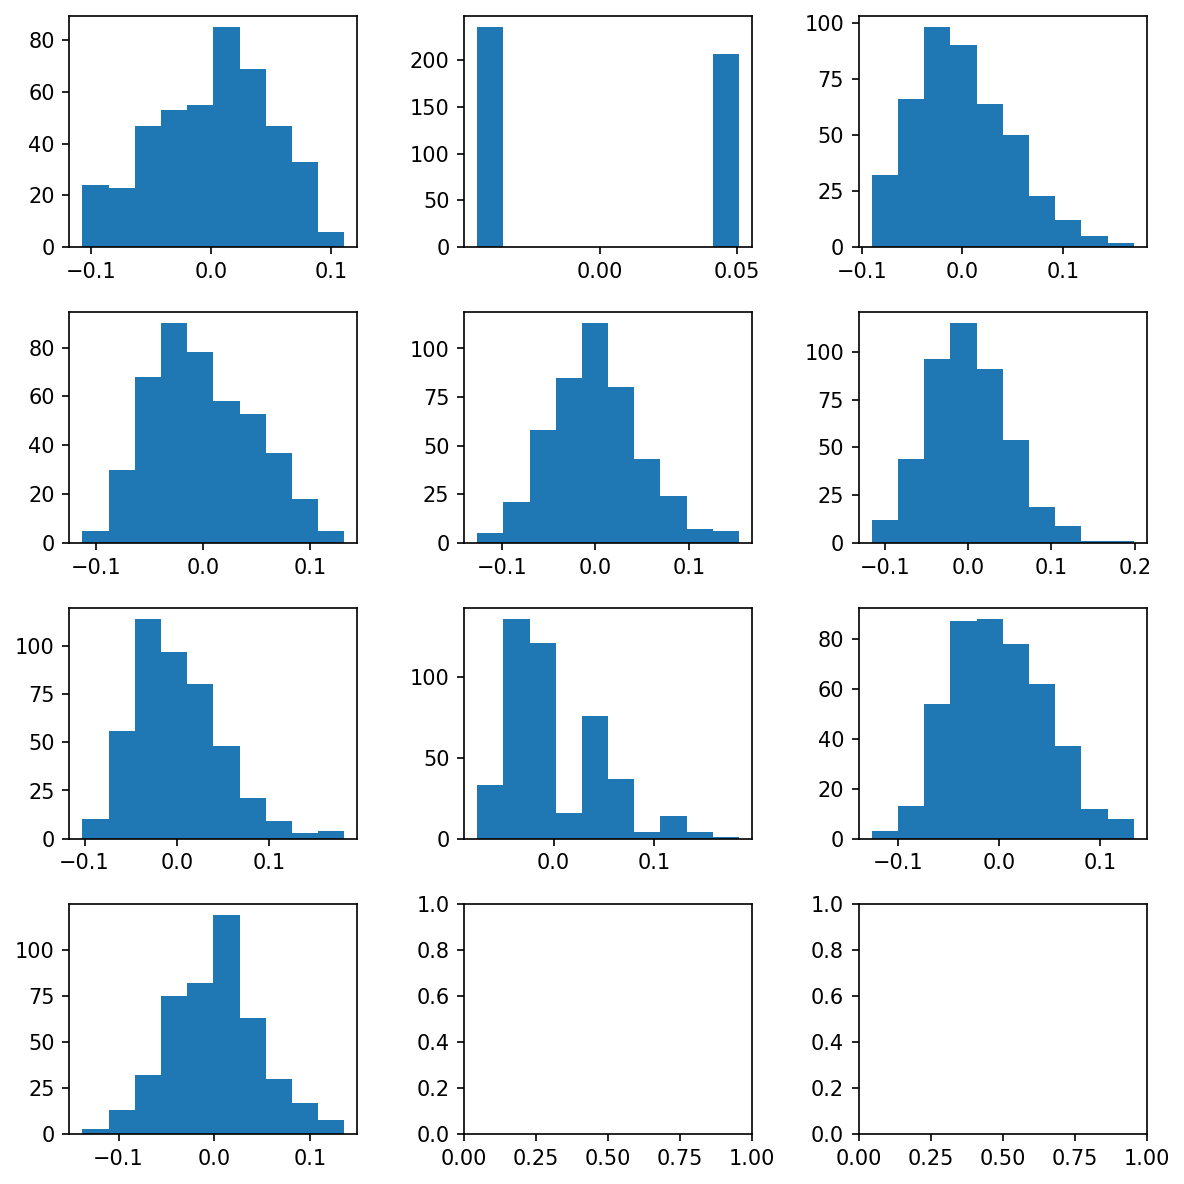

In [8]:
fig, axes = plt.subplots(4, 3, figsize = (8, 8), dpi = 150)
axes = axes.ravel()

for i in range(X.shape[1]): # iterate through columns
    axes[i].hist(X[:, i]) # Plot the histogram of i-th column of the X matrix
    
plt.tight_layout() # Makes the plot look nicer

## 2b: Optimize the hyperparameter of a LASSO model

Create a LASSO model and find the optimum value of the regularization strength, `alpha`. You should ensure that the model is fitting an intercept, and use 5-fold cross-validation to identify the optimal hyperparameter. You can search over the following parameter ranges:

$\alpha \in [0.001, 0.005, 0.01, 0.05, 0.1]$

Store the optimum alpha value as `alpha_opt`.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alphas = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
param_grid = {'alpha': alphas}

LASSO = Lasso(fit_intercept=True)

lasso_search = GridSearchCV(LASSO, param_grid, cv = 5)
lasso_search.fit(X, y_regress)
alpha_opt = lasso_search.best_estimator_.alpha

In [10]:
print("Optimum alpha for LASSO model: {}".format(alpha_opt))

Optimum alpha for LASSO model: 0.005


## 2c: Ensemble of LASSO models

Use 5-fold cross validation to create an ensemble of 5 different LASSO models. Use the optimum value of `alpha`from the prior problem, and be sure to fit an intercept. If you were unable to complete the prior problem you can use `alpha=0.1`. For each model, print out the **$r^2$ score for the full dataset** and the **indices of any columns that are dropped from the model**.

In [11]:
### BEGIN SOLUTION ###
from sklearn.model_selection import KFold

kfold = KFold(n_splits = 5, shuffle = True)

yhatList = []

i=0
for train_index, test_index in kfold.split(X):
    i += 1
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y_regress[train_index], y_regress[test_index]
    
    LASSO = Lasso(alpha = 0.05)
    LASSO.fit(x_train, y_train)
    r2 = LASSO.score(X, y_regress)
    coefs = LASSO.coef_
    dropped = np.array(range(X.shape[1]))[coefs==0]
    print("Model {}: r^2={}, dropped column indices={}".format(i, r2, dropped))
### END SOLUTION

Model 1: r^2=0.5143886864585369, dropped column indices=[0 5]
Model 2: r^2=0.5126623666238104, dropped column indices=[5 7]
Model 3: r^2=0.5047330522938007, dropped column indices=[0 5]
Model 4: r^2=0.5127095633015475, dropped column indices=[5 7]
Model 5: r^2=0.5093639995239168, dropped column indices=[0 5 7]


Note: The following code may be useful for printing the required information.

`print("Model {}: r^2={}, dropped column indices={}".format(i, r2, dropped))`

where `i` is the index of a given model corresponding to one of the train/test splits, `r2` is the $r^2$ score of the model, and `dropped` is a list of indices of all dropped columns. If you have trouble figuring out which columns are dropped you can just print the coefficients of the model for nearly full credit.

# Problem 3: Classification

This problem will check for understanding of how a decision boundary is defined in a classification model, and will test your ability to optimize and evaluate a practical classification model. You may use any libraries, including `scikit-learn` for this problem. You will work with the `y_class` vector which uses class labels of [-1, 1] to identify whether or not a patient has diabetes (1) or not (-1).

## 3a: Plotting a decision boundary for a 2D logistic regression model

In this problem you will work with only columns 2 and 3 of the original dataset (`X[:, [2,3]`). You should train a logistic regression model with no regularization and plot the resulting decision boundary. You may do this using optimization of the softmax loss function, or with `scikit-learn`. If you choose to use optimization, you can use an initial guess of `w0=[1,1,1]`. Note that if you choose to use `scikit-learn` you will need to remove regularization by setting `C` to a very large number (e.g. 1e13).

[-0.40338494 22.05378669 14.20630075]


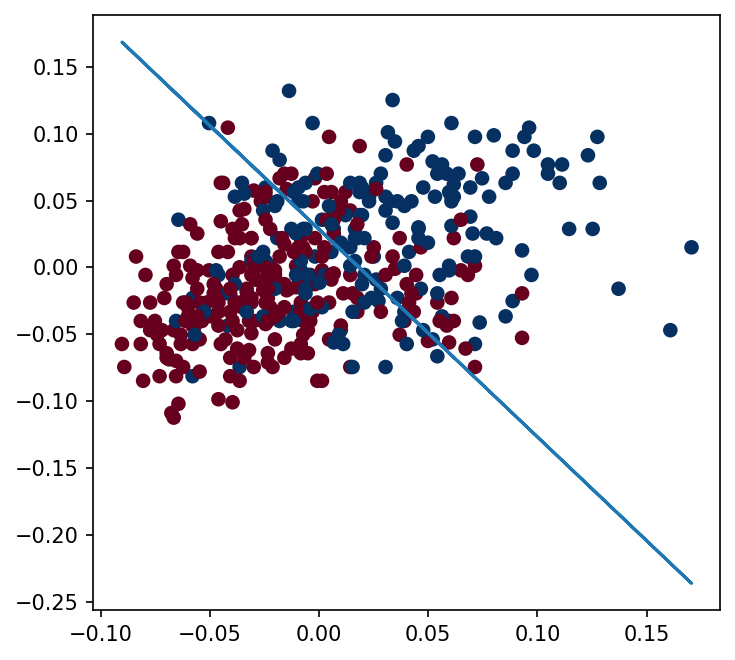

In [12]:
from scipy.optimize import minimize
X_2d = X[:, [2,3]]

def softmax_cost(w, X = X_2d, y = y_class):
    X_intercept = np.hstack((np.ones((X.shape[0],1)),X))
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    return sum(np.log(1 + exp_yXb))


w0 = [1,1,1]
result = minimize(softmax_cost, w0, args = (X_2d, y_class))
w_logit = result.x
print(w_logit)

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.scatter(X_2d[:,0], X_2d[:,1], c=y_class, cmap='RdBu')

m = -w_logit[1] / w_logit[2]
b = -w_logit[0] / w_logit[2]
ax.plot(X_2d[:, 0], m*X_2d[:, 0] + b, ls = '-')

plt.tight_layout()

## 3b: Evaluating a support vector machine model

Train a kernel support vector classification model for the full dataset, including all columns. Use the `rbf` kernel with `gamma=10` and `C=10`. Train the model on every second point, and report the accuracy, precision, and recall for the full dataset. As a reminder, accuracy, precision and recall are defined as:

* Accuracy = (number correct)/(total) = (TP + TN)/(TP + TN + FP + FN)
* Precision = TP/(TP + FP)
* Recall = TP/(TP + FN)

Store your answers in variables named `accuracy`, `precision`, and `recall`. If the assertion statement passes it means your solution is likely correct.

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

svc = SVC(kernel = 'rbf', gamma = 10, C = 10)
svc.fit(X[::2], y_class[::2])
y_predict = svc.predict(X)

cm = confusion_matrix(y_class, y_predict)
tn, fp, fn, tp = cm.reshape(-1,)

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [14]:
accuracy * precision * recall

0.42770794135558404

In [15]:
assert np.isclose(accuracy*precision*recall, 0.42770794135558404)